# Python: Conditional Average Treatment Effects (CATEs) for PLR models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate conditional average treatment effects with B-splines for one or two-dimensional effects in the [DoubleMLPLR](https://docs.doubleml.org/stable/guide/models.html#partially-linear-regression-model-plr) model.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/dev/api/api.html#dataset-generators).

## One-dimensional Example

We start with an one-dimensional effect and create our training data. In this example the true effect depends only the first covariate $X_0$ and takes the following form

$$
\theta_0(X) = \exp(2X_0) + 3\sin(4X_0).
$$

The generated dictionary also contains a callable with key `treatment_effect` to calculate the true treatment effect for new observations.

In [2]:
np.random.seed(42)
data_dict = make_heterogeneous_data(
    n_obs=2000,
    p=10,
    support_size=5,
    n_x=1,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
print(data.head())

          y         d       X_0       X_1       X_2       X_3       X_4  \
0  1.564451  0.241064  0.259828  0.886086  0.895690  0.297287  0.229994   
1  1.114570  0.040912  0.824350  0.396992  0.156317  0.737951  0.360475   
2  8.901013  1.392623  0.988421  0.977280  0.793818  0.659423  0.577807   
3 -1.315155 -0.551317  0.427486  0.330285  0.564232  0.850575  0.201528   
4  1.314625  0.683487  0.016200  0.818380  0.040139  0.889913  0.991963   

        X_5       X_6       X_7       X_8       X_9  
0  0.411304  0.240532  0.672384  0.826065  0.673092  
1  0.671271  0.270644  0.081230  0.992582  0.156202  
2  0.866102  0.289440  0.467681  0.619390  0.411190  
3  0.934433  0.689088  0.823273  0.556191  0.779517  
4  0.294067  0.210319  0.765363  0.253026  0.865562  


First, define the ``DoubleMLData`` object.

In [3]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

Next, define the learners for the nuisance functions and fit the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html). Remark that linear learners would usually be optimal due to the data generating process.

In [4]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model


       coef   std err          t  P>|t|     2.5 %    97.5 %
d  4.377669  0.043998  99.497422    0.0  4.291434  4.463903


To estimate the CATE, we rely on the best-linear-predictor of the linear score as in [Semenova et al. (2021)](https://doi.org/10.1093/ectj/utaa027) To approximate the target function $\theta_0(x)$ with a linear form, we have to define a data frame of basis functions. Here, we rely on [patsy](https://patsy.readthedocs.io/en/latest/) to construct a suitable basis of [B-splines](https://en.wikipedia.org/wiki/B-spline).

In [5]:
import patsy
design_matrix = patsy.dmatrix("bs(x, df=5, degree=2)", {"x": data["X_0"]})
spline_basis = pd.DataFrame(design_matrix)

To estimate the parameters to calculate the CATE estimate call the ``cate()`` method and supply the dataframe of basis elements.

In [6]:
cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err          t          P>|t|    [0.025    0.975]
0  1.239313  0.141729   8.744228   4.675733e-18  0.961360  1.517266
1  1.581849  0.237292   6.666259   3.385877e-11  1.116483  2.047215
2  4.178218  0.150136  27.829619  2.742758e-144  3.883778  4.472657
3  4.040919  0.182692  22.118721   3.950131e-97  3.682631  4.399207
4  3.272408  0.186795  17.518682   5.025783e-64  2.906073  3.638742
5  3.796384  0.194232  19.545602   5.614185e-78  3.415465  4.177304


To obtain the confidence intervals for the CATE, we have to call the ``confint()`` method and a supply a dataframe of basis elements.
This could be the same basis as for fitting the CATE model or a new basis to e.g. evaluate the CATE model on a grid.
Here, we will evaluate the CATE on a grid from 0.1 to 0.9 to plot the final results.
Further, we construct uniform confidence intervals by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [7]:
new_data = {"x": np.linspace(0.1, 0.9, 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
print(df_cate)

       2.5 %    effect    97.5 %
0   2.199412  2.429057  2.658702
1   2.289357  2.521611  2.753866
2   2.376806  2.613622  2.850439
3   2.462567  2.705090  2.947613
4   2.547324  2.796014  3.044704
..       ...       ...       ...
95  4.494089  4.734770  4.975450
96  4.502901  4.738065  4.973229
97  4.514173  4.743341  4.972509
98  4.527452  4.750597  4.973741
99  4.542159  4.759833  4.977507

[100 rows x 3 columns]


Finally, we can plot our results and compare them with the true effect.

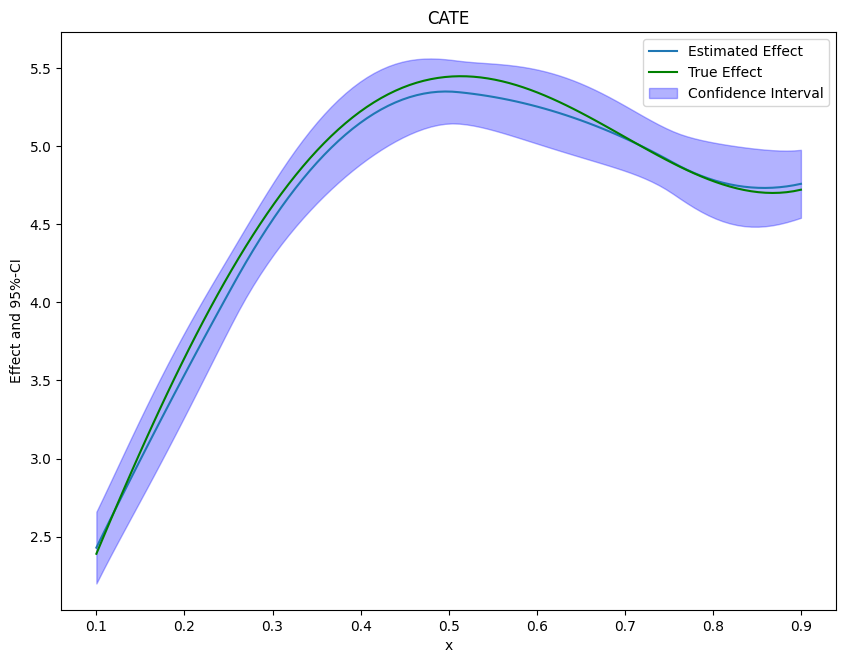

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

df_cate['x'] = new_data['x']
df_cate['true_effect'] = treatment_effect(new_data["x"].reshape(-1, 1))
fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['true_effect'], color="green", label='True Effect')
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='b', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

If the effect is not one-dimensional, the estimate still corresponds to the projection of the true effect on the basis functions.

## Two-Dimensional Example

It is also possible to estimate multi-dimensional conditional effects. We will use a similar data generating process but now the effect depends on the first two covariates $X_0$ and $X_1$ and takes the following form
$$
\theta_0(X) = \exp(2X_0) + 3\sin(4X_1).
$$

With the argument ``n_x=2`` we can specify set the effect to be two-dimensional.

In [9]:
np.random.seed(42)
data_dict = make_heterogeneous_data(
    n_obs=5000,
    p=10,
    support_size=5,
    n_x=2,
)
treatment_effect = data_dict['treatment_effect']
data = data_dict['data']
print(data.head())

          y         d       X_0       X_1       X_2       X_3       X_4  \
0 -0.359307 -0.479722  0.014080  0.006958  0.240127  0.100807  0.260211   
1  0.578557 -0.587135  0.152148  0.912230  0.892796  0.653901  0.672234   
2  1.479882  0.172083  0.344787  0.893649  0.291517  0.562712  0.099731   
3  4.468072  0.480579  0.619351  0.232134  0.000943  0.757151  0.985207   
4  5.949866  0.974213  0.477130  0.447624  0.775191  0.526769  0.316717   

        X_5       X_6       X_7       X_8       X_9  
0  0.177043  0.028520  0.909304  0.008223  0.736082  
1  0.005339  0.984872  0.877833  0.895106  0.659245  
2  0.921956  0.140770  0.224897  0.558134  0.764093  
3  0.809913  0.460207  0.903767  0.409848  0.524934  
4  0.258158  0.037747  0.583195  0.229961  0.148134  


As univariate example estimate the [PLR Model](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html).

In [10]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [11]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_l = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestRegressor(n_estimators=500)

np.random.seed(42)

dml_plr = dml.DoubleMLPLR(data_dml_base,
                          ml_l=ml_l,
                          ml_m=ml_m,
                          n_folds=5)
print("Training PLR Model")
dml_plr.fit()

print(dml_plr.summary)

Training PLR Model


       coef  std err          t  P>|t|     2.5 %    97.5 %
d  4.469895  0.04973  89.883485    0.0  4.372427  4.567364


As above, we will rely on the [patsy](https://patsy.readthedocs.io/en/latest/) package to construct the basis elements.
In the two-dimensional case, we will construct a tensor product of B-splines (for more information see [here](https://patsy.readthedocs.io/en/latest/spline-regression.html#tensor-product-smooths)).

In [12]:
design_matrix = patsy.dmatrix("te(bs(x_0, df=7, degree=3), bs(x_1, df=7, degree=3))", {"x_0": data["X_0"], "x_1": data["X_1"]})
spline_basis = pd.DataFrame(design_matrix)

cate = dml_plr.cate(spline_basis)
print(cate)

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
        coef   std err          t          P>|t|    [0.025     0.975]
0   2.785038  0.103186  26.990377  8.380432e-150  2.582747   2.987329
1  -3.326148  0.865540  -3.842859   1.231330e-04 -5.022991  -1.629306
2   3.068073  0.886989   3.458976   5.468051e-04  1.329181   4.806964
3   1.733047  0.768331   2.255598   2.413933e-02  0.226776   3.239317
4   2.016011  0.772253   2.610559   9.066689e-03  0.502054   3.529969
5  -3.886041  0.929598  -4.180348   2.960875e-05 -5.708465  -2.063618
6  -5.448842  1.011511  -5.386834   7.502843e-08 -7.431852  -3.465832
7  -7.348700  0.916806  -8.015548   1.356886e-15 -9.146046  -5.551355
8  -0.629549  0.909141  -0.692465   4.886777e-01 -2.411869   1.152772
9  -0.213070  0.963051  -0.221245   8.249109e-01 -2.101076   1.674936
10  1.905042  0.826391   2.305255   2.119348e-02  0.284949   3.525135
11  0.572991  0.826215   0.693513   4.880202e-01 -1.

Finally, we create a new grid to evaluate and plot the effects.

In [13]:
grid_size = 100
x_0 = np.linspace(0.1, 0.9, grid_size)
x_1 = np.linspace(0.1, 0.9, grid_size)
x_0, x_1 = np.meshgrid(x_0, x_1)

new_data = {"x_0": x_0.ravel(), "x_1": x_1.ravel()}

In [14]:
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], new_data)[0])
df_cate = cate.confint(spline_grid, joint=True, n_rep_boot=2000)
print(df_cate)

         2.5 %    effect    97.5 %
0     1.333704  2.035264  2.736823
1     1.349638  2.035441  2.721245
2     1.376760  2.042249  2.707738
3     1.412726  2.055171  2.697616
4     1.455091  2.073694  2.692297
...        ...       ...       ...
9995  3.543691  4.251412  4.959132
9996  3.582146  4.332502  5.082858
9997  3.619128  4.416132  5.213135
9998  3.659339  4.502595  5.345852
9999  3.707125  4.592186  5.477247

[10000 rows x 3 columns]


In [15]:
import plotly.graph_objects as go

grid_array = np.array(list(zip(x_0.ravel(), x_1.ravel())))
true_effect = treatment_effect(grid_array).reshape(x_0.shape)
effect = np.asarray(df_cate['effect']).reshape(x_0.shape)
lower_bound = np.asarray(df_cate['2.5 %']).reshape(x_0.shape)
upper_bound = np.asarray(df_cate['97.5 %']).reshape(x_0.shape)

fig = go.Figure(data=[
    go.Surface(x=x_0,
               y=x_1,
               z=true_effect),
    go.Surface(x=x_0,
               y=x_1,
               z=upper_bound, showscale=False, opacity=0.4,colorscale='purp'),
    go.Surface(x=x_0,
               y=x_1,
               z=lower_bound, showscale=False, opacity=0.4,colorscale='purp'),
])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(scene = dict(
                    xaxis_title='X_0',
                    yaxis_title='X_1',
                    zaxis_title='Effect'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()